In [187]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
from tqdm import tqdm
%matplotlib inline

# Read in borough park polygon

In [120]:
borough_park = gpd.read_file("../data/neighborhood_tabulation_areas/top_predictions/borough_park.shp")
borough_park.crs = {'init' :'epsg:4326'}
polygon = borough_park.loc[0]['geometry']

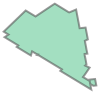

In [121]:
polygon

# Read in borough park intersections

In [7]:
intersections = gpd.read_file("../data/neighborhood_tabulation_areas/top_predictions/borough_park_intersections/borough_park_intersections.shp")

In [8]:
intersections.crs = {'init' :'epsg:3857'}

In [9]:
intersections.head()

,id,geometry
0,0,POINT (-8234747.733642889 4955578.345774663)
1,1,POINT (-8234878.478384824 4955678.563065642)
2,2,POINT (-8235062.712142089 4955686.33530107)
3,3,POINT (-8234995.47516965 4955771.68365043)
4,4,POINT (-8234897.614205291 4955818.654889079)


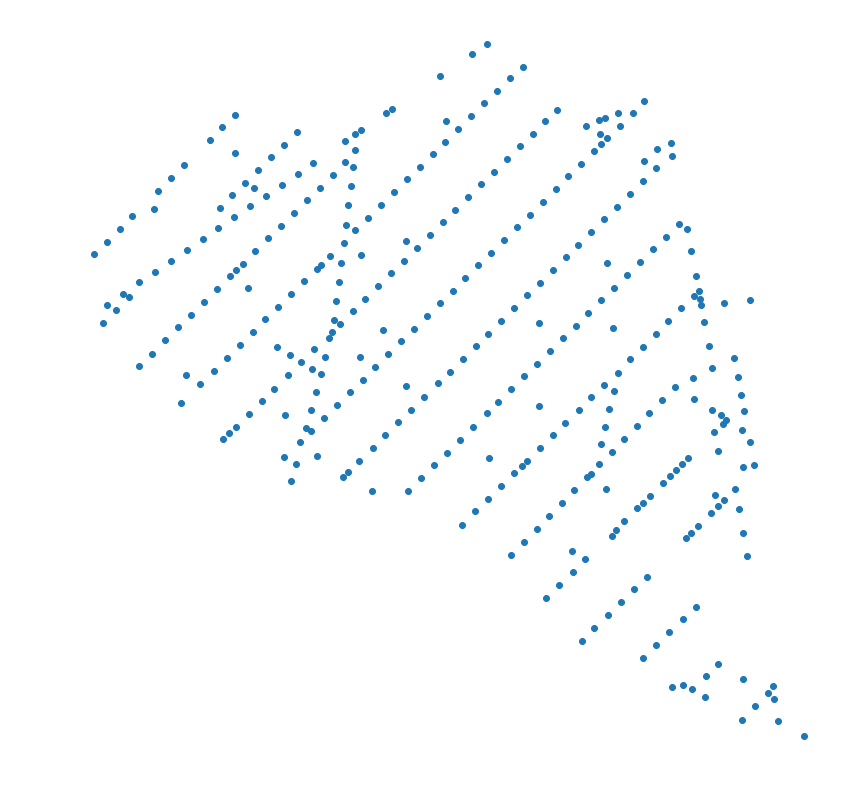

In [10]:
f, ax = plt.subplots(figsize=(14,14))
ax.set_axis_off()
intersections.plot(ax=ax);

In [11]:
intersections.crs

{'init': 'epsg:3857'}

# Read in jobs

In [12]:
df = pd.read_csv("../data/origin_destination_employment/LODES_NYC.csv")

In [13]:
jobs = df[['dest_lat', 'dest_lon']]
jobs.columns = ['latitude', 'longitude']
geometry = [Point(xy) for xy in zip(jobs.longitude, jobs.latitude)]
crs = {'init': 'epsg:4326'}
jobs = gpd.GeoDataFrame(jobs, crs=crs, geometry=geometry)

In [14]:
jobs.head()

,latitude,longitude,geometry
0,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
1,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
2,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
3,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)
4,40.792936,-73.881206,POINT (-73.88120649999999 40.7929362)


In [15]:
%%time

# clip jobs to include only those within borough park
borough_park_jobs = gpd.sjoin(jobs, borough_park, how="inner", op='intersects')

CPU times: user 1min 24s, sys: 1.07 s, total: 1min 26s
Wall time: 1min 26s


In [16]:
borough_park_jobs.shape

(38235, 10)

In [17]:
borough_park_jobs.head()

,latitude,longitude,geometry,index_right,NTACode,NTAName,Borough,Year,Population,numStation
323804,40.641081,-73.998366,POINT (-73.99836590000001 40.6410808),0,BK88,Borough Park,Brooklyn,2010,106357,0
323805,40.641081,-73.998366,POINT (-73.99836590000001 40.6410808),0,BK88,Borough Park,Brooklyn,2010,106357,0
323806,40.641081,-73.998366,POINT (-73.99836590000001 40.6410808),0,BK88,Borough Park,Brooklyn,2010,106357,0
323807,40.641081,-73.998366,POINT (-73.99836590000001 40.6410808),0,BK88,Borough Park,Brooklyn,2010,106357,0
323808,40.641081,-73.998366,POINT (-73.99836590000001 40.6410808),0,BK88,Borough Park,Brooklyn,2010,106357,0


In [18]:
borough_park_jobs.crs

{'init': 'epsg:4326'}

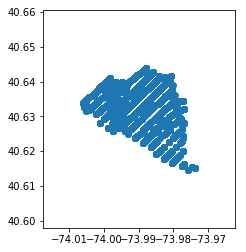

In [22]:
borough_park_jobs.plot()

In [19]:
%%time
# reproject to 3857 so we can use meters to set radius later
borough_park_jobs_3857 = borough_park_jobs.to_crs({'init': 'epsg:3857'})

CPU times: user 1.07 s, sys: 8.84 ms, total: 1.07 s
Wall time: 1.07 s


In [20]:
borough_park_jobs_3857.head()

,latitude,longitude,geometry,index_right,NTACode,NTAName,Borough,Year,Population,numStation
323804,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),0,BK88,Borough Park,Brooklyn,2010,106357,0
323805,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),0,BK88,Borough Park,Brooklyn,2010,106357,0
323806,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),0,BK88,Borough Park,Brooklyn,2010,106357,0
323807,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),0,BK88,Borough Park,Brooklyn,2010,106357,0
323808,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),0,BK88,Borough Park,Brooklyn,2010,106357,0


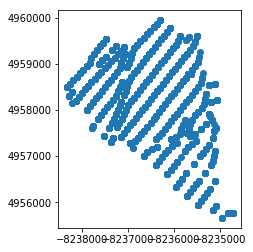

In [25]:
borough_park_jobs_3857.plot();

In [26]:
len(borough_park_jobs)

38235

In [29]:
from scipy import ndimage

In [30]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


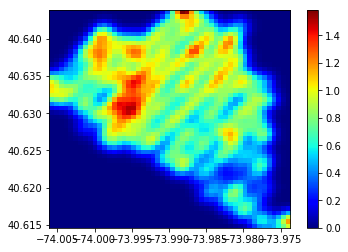

In [31]:
heatmap(borough_park_jobs, bins=50, smoothing=1.5)

# Read in population

In [32]:
population = df[['origin_lat', 'origin_lon']]
population.columns = ['latitude', 'longitude']

population = df[['origin_lat', 'origin_lon']]
population.columns = ['latitude', 'longitude']
geometry = [Point(xy) for xy in zip(population.longitude, population.latitude)]
crs = {'init': 'epsg:4326'}
population = gpd.GeoDataFrame(population, crs=crs, geometry=geometry)

In [33]:
%%time

# clip population to include only those within borough park
borough_park_population = gpd.sjoin(population, borough_park, how="inner", op='intersects')

CPU times: user 1min 28s, sys: 1.33 s, total: 1min 30s
Wall time: 1min 30s


In [34]:
# reproject to 3857 so we can use meters to set radius later
%time
borough_park_population_3857 = borough_park_population.to_crs({'init': 'epsg:3857'})

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [35]:
borough_park_population_3857.shape

(24166, 10)

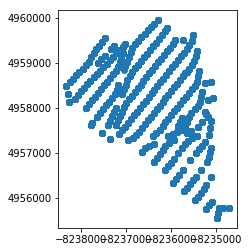

In [36]:
borough_park_population_3857.plot();

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


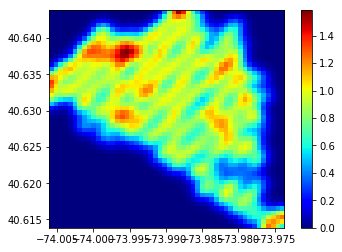

In [37]:
heatmap(borough_park_population, bins=50, smoothing=1.5)

# Read in subway volumes

In [96]:
september_subway = pd.read_csv("../data/subway_turnstiles/september2017_subway_volumes.csv")

In [97]:
crs = {'init': 'epsg:4326'}
geom = [Point(xy) for xy in zip(september_subway['longitude'], september_subway['latitude'])]
september_subway = gpd.GeoDataFrame(september_subway, geometry=geom, crs=crs)

In [98]:
september_subway.head()

,Unnamed: 0,Station,yearMonth,Exits,Entries,Total_Volume,station_name,latitude,longitude,geometry
0,0,1 AV,201709,412637,388384,801021,1 AV,40.768655,-73.958426,POINT (-73.95842590000001 40.7686549)
1,1,103 ST,201709,391889,613681,1005570,103 ST,40.796088,-73.961453,POINT (-73.96145260000002 40.7960878)
2,2,103 ST-CORONA,201709,3437856,11942506,15380362,103 ST-CORONA,40.749779,-73.862646,POINT (-73.86264609999998 40.7497795)
3,3,104 ST,201709,13628,63030,76658,104 ST,40.681333,-73.838846,POINT (-73.83884570000001 40.6813328)
4,4,110 ST,201709,160893,224511,385404,110 ST,40.798483,-73.952613,POINT (-73.95261309999999 40.7984831)


In [99]:
september_subway.shape

(378, 10)

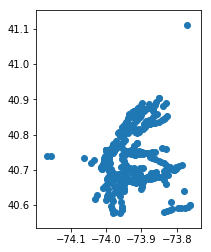

In [100]:
september_subway.plot()

In [101]:
september_subway.crs

{'init': 'epsg:4326'}

In [122]:
borough_park_buffer = borough_park.copy()
borough_park_buffer['geometry'] = borough_park_buffer['geometry'].buffer(0.01)

In [123]:
# clip population to include only those within borough park
borough_park_september_subway = gpd.sjoin(september_subway, borough_park_buffer, how="inner", op='intersects')

In [124]:
borough_park_september_subway.crs

{'init': 'epsg:4326'}

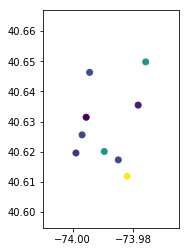

In [125]:
borough_park_september_subway.plot(column='Total_Volume')

In [127]:
borough_park_september_subway.to_file("../data/subway_turnstiles/september2017_subway_volumes_borough_park.csv")

In [135]:
borough_park_september_subway_3857 = borough_park_september_subway.to_crs({'init': 'epsg:3857'})

# For every intersection, calculate nearby jobs, population and subway volume

In [169]:
del borough_park_jobs_3857['index_right']
borough_park_jobs_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
323804,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323805,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323806,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323807,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0
323808,40.641081,-73.998366,POINT (-8237460.411522339 4959544.442247306),BK88,Borough Park,Brooklyn,2010,106357,0


In [170]:
del borough_park_population_3857['index_right']
borough_park_population_3857.head()

,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
719,40.636461,-73.981659,POINT (-8235600.596789655 4958866.73823975),BK88,Borough Park,Brooklyn,2010,106357,0
1632,40.639891,-73.988850,POINT (-8236401.106379899 4959369.851633735),BK88,Borough Park,Brooklyn,2010,106357,0
1933,40.633034,-74.003162,POINT (-8237994.322064081 4958363.988068293),BK88,Borough Park,Brooklyn,2010,106357,0
1936,40.634640,-73.990726,POINT (-8236609.919480728 4958599.598114852),BK88,Borough Park,Brooklyn,2010,106357,0
2705,40.632563,-73.985759,POINT (-8236057.062361654 4958294.987170252),BK88,Borough Park,Brooklyn,2010,106357,0


In [171]:
del borough_park_september_subway_3857['index_right']
borough_park_september_subway_3857.head()

,Unnamed: 0,Station,yearMonth,Exits,Entries,Total_Volume,station_name,latitude,longitude,geometry,NTACode,NTAName,Borough,Year,Population,numStation
31,31,18 AV,201709,102161,275497,377658,18 AV,40.620091,-73.989482,POINT (-8236471.493693925 4956465.643189163),BK88,Borough Park,Brooklyn,2010,106357,0
39,39,20 AV,201709,28004,159106,187110,20 AV,40.617304,-73.984833,POINT (-8235953.913721482 4956056.946106019),BK88,Borough Park,Brooklyn,2010,106357,0
82,82,55 ST,201709,16548,37654,54202,55 ST,40.631435,-73.995476,POINT (-8237138.709325896 4958129.469140499),BK88,Borough Park,Brooklyn,2010,106357,0
96,96,71 ST,201709,33304,116680,149984,71 ST,40.619589,-73.998864,POINT (-8237515.859760704 4956392.021313072),BK88,Borough Park,Brooklyn,2010,106357,0
113,113,9 AV,201709,93030,111850,204880,9 AV,40.646292,-73.994324,POINT (-8237010.469272499 4960308.974836171),BK88,Borough Park,Brooklyn,2010,106357,0


In [172]:
intersections.head()

,id,geometry
0,0,POINT (-8234747.733642889 4955578.345774663)
1,1,POINT (-8234878.478384824 4955678.563065642)
2,2,POINT (-8235062.712142089 4955686.33530107)
3,3,POINT (-8234995.47516965 4955771.68365043)
4,4,POINT (-8234897.614205291 4955818.654889079)


In [208]:
# 800 meter buffer = approx 0.5 miles
intersections_buffer = intersections.copy()
intersections_buffer['geometry'] = intersections_buffer.buffer(800)

In [209]:
ids = []
jobs = []
populations = []
subway_volumes = []

for i in tqdm(intersections_buffer.index):
    
    ids.append(i)
    
    node = intersections_buffer.loc[[i]]
    
    # count jobs
    job_join = gpd.sjoin(borough_park_jobs_3857, node, how='inner', op='intersects')
    job_count = len(job_join)
    jobs.append(job_count)
    
    # count people
    population_join = gpd.sjoin(borough_park_population_3857, node, how='inner', op='intersects')
    population_count = len(population_join)
    populations.append(population_count)
    
    # sum subway volumes
    subway_join = gpd.sjoin(borough_park_september_subway_3857, node, how='inner', op='intersects')
    subway_sum = subway_join['Total_Volume'].sum()
    subway_volumes.append(subway_sum)

100%|██████████| 361/361 [12:23<00:00,  2.06s/it]


In [353]:
results = pd.DataFrame()
results['id'] = ids
results['jobs'] = jobs
results['population'] = populations
results['subway_volume'] = subway_volumes
results['total'] = results['jobs'] + results['population'] + results['subway_volume'] / 300

In [354]:
results.sort_values('total', ascending=False).head(10)

,id,jobs,population,subway_volume,total
351,351,13677,6649,54202,20506.673333
277,277,14199,6219,0,20418.000000
345,345,13648,6227,54202,20055.673333
261,261,13666,6264,0,19930.000000
276,276,13505,6325,0,19830.000000
249,249,13623,6014,54202,19817.673333
231,231,13503,5940,54202,19623.673333
349,349,13561,5803,54202,19544.673333
216,216,13523,5791,54202,19494.673333
253,253,13286,6011,54202,19477.673333


In [387]:
top_ids = list(results.sort_values('total', ascending=False).head(25)['id'])

In [388]:
intersections_test = intersections.copy()

In [389]:
intersections_test['query'] = 0

In [390]:
for i in top_ids:
    intersections_test.ix[i, 'query'] = 1

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


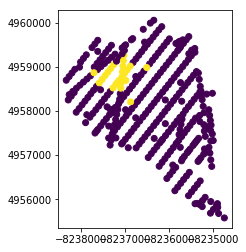

In [391]:
intersections_test.plot(column='query')

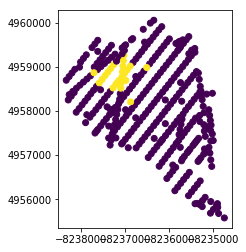

In [392]:
intersections_test.plot(column='query')